# Library import

In [1]:
import numpy as np
from skimage import io, color, exposure, transform
from skimage.color import rgb2gray
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split  #it came from update scikit learn. https://stackoverflow.com/questions/40704484/importerror-no-module-named-model-selection
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D,Conv1D
from keras.layers.pooling import MaxPooling2D

from keras.layers.convolutional import Convolution2D, MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_first')

from matplotlib import pyplot as plt
%matplotlib inline

#import keras

NUM_CLASSES = 9  #how many different type of class/type of image you are using. Like CAT,DOG, ELEPHANT etc
IMG_SIZE = 8  # You can change it. Always keep same size for width and height. That means square size.
number_filter = 5

Using TensorFlow backend.


# Function for preprocessing image. Able for RGB & Gray Image

In [2]:
#for gray scale
def preprocess_img(img):
    # Histogram normalization in y
#     hsv = color.rgb2hsv(img)
#     hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
#     img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]
    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img

def get_class(img_path):
    return int(img_path.split('/')[-2])

# Store the image and label in array. Run this cell if you need to do training. For testing no need to run it

In [3]:
imgs = []
labels = []
root_dir = '/home/atif/training_by_several_learning_process/number_classify/rgb_2_gray/Image-classification/train_image/'
#path='/home/atif/training_by_several_learning_process/flower_photos/00000/'

#all_img_paths = glob.glob(path+ '5547758_eea9edfd54_n_000.jpg')

all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm')) #I have done the training with .ppm format image. If another type of image will come 
                                                                                    #them .ppm will be changed by that extension
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    try:
        img = preprocess_img(io.imread(img_path))
        label = get_class(img_path)
        imgs.append(img)
        labels.append(label)

        if len(imgs)%1000 == 0: print("Processed {}/{}".format(len(imgs), len(all_img_paths)))
            #print("get it 2")
    except (IOError, OSError):
        print('missed', img_path)
        pass

X = np.array(imgs, dtype='float32') #Keeping the image as an array
Y = np.eye(NUM_CLASSES, dtype='uint8')[labels] #labels of the image

/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Processed 1000/11760
Processed 2000/11760
Processed 3000/11760
Processed 4000/11760
Processed 5000/11760
Processed 6000/11760
Processed 7000/11760
Processed 8000/11760
Processed 9000/11760
Processed 10000/11760
Processed 11000/11760


In [4]:
print(X)

[[[0.87966925 0.21742298 0.18823698 ... 0.20163527 0.1623446  0.19858555]
  [0.34627584 0.20389156 0.41243085 ... 0.38479063 0.18634371 0.20910794]
  [0.5084503  0.38818428 0.4227144  ... 0.68279886 0.4094494  0.23253906]
  ...
  [0.94248456 0.50402987 0.6156635  ... 0.56015205 0.28019923 0.1566745 ]
  [0.3540366  0.22810185 0.39233884 ... 0.29555655 0.24871218 0.14428936]
  [0.27633914 0.196739   0.17851153 ... 0.1390104  0.10601932 0.21071902]]

 [[0.9651243  0.92070544 0.8416287  ... 0.8300371  0.68007725 0.9667377 ]
  [0.9348549  0.9341597  0.9705955  ... 0.8633098  0.8277495  0.9391453 ]
  [0.7468351  0.93905383 0.3480737  ... 0.38256475 0.6820426  0.9426031 ]
  ...
  [0.7441497  0.84143347 0.34808463 ... 0.6190271  0.3831098  0.9893017 ]
  [0.5018094  0.36299777 0.38730145 ... 0.36066535 0.94458115 0.6681786 ]
  [0.8131038  0.34702766 0.55971247 ... 0.6287379  0.64277613 0.7468819 ]]

 [[1.         1.         1.         ... 1.         1.         0.70635587]
  [1.         1.      

In [15]:
# X = np.array(imgs, dtype='float32')
print(X.shape)
#plt.imshow(X[0])
# plt.imshow(X[0],cmap="gray")
# plt.imshow(X[0]) #if you use this command here you will see something coloured image. No problem, it is gray image. 
                        #To see full Black and white image uncomment the previous line.
X = X.reshape(len(imgs),1,IMG_SIZE,IMG_SIZE) # write (IMG_SIZE,IMG_SIZE,1 if you want channel last; 1= grayscale;3=RGB)
# plt.imshow(X[0],cmap="gray")
print(X.shape)
print(X.ndim)
print(X[0].shape)

(11760, 1, 8, 8)
(11760, 1, 8, 8)
4
(1, 8, 8)


In [16]:
print(X.shape)
print(Y.shape)

(11760, 1, 8, 8)
(11760, 9)


# making a model. Run it for training and testing

In [17]:
# This model is for understanding the inner calculation of CNN that's why I have started witha minimal layer as well as model.
# Increase the filter number and layer if you want a good result
#Conv2D(1, (3, 3) >> here 1 = number of filter. (3,3) = kernel height and width
# you can just add padding just beside Conv2D. (model.add(Conv2D(1,(3,3)),padding='same',....))
# I haven't added here for remove complexity in c++(I have tried to implement this whole model in testing phase in cpp)
def cnn_model():
#      padding='same'
    model = Sequential()

    model.add(Conv2D(number_filter, (3, 3),
                     input_shape=(1,IMG_SIZE, IMG_SIZE),
                     activation='relu'))
    model.add(Flatten())
#     model.add(Dense(512, activation='relu'))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    
    return model

model = cnn_model()

lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 5, 6, 6)           50        
_________________________________________________________________
flatten_1 (Flatten)          (None, 180)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 1629      
Total params: 1,679
Trainable params: 1,679
Non-trainable params: 0
_________________________________________________________________


# Training phase. Storing the model also for further use

In [19]:
def lr_schedule(epoch):
    return lr * (0.1 ** int(epoch / 10))

batch_size = 32
epochs = 100
train_model= model.fit(X, Y,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
          #np.resize(img, (-1, <image shape>)
          callbacks=[LearningRateScheduler(lr_schedule),ModelCheckpoint('/home/atif/training_by_several_learning_process/number_classify/rgb_2_gray/Image-classification/trained_model_text_file/image_size_8_data_type_float_trained_model/traffic_model_14_march_ep_100_int_val.h5', save_best_only=True)])

Train on 9408 samples, validate on 2352 samples
Epoch 1/100
9408/9408 [==============================] - 2s 248us/step - loss: 1.8274 - acc: 0.2851 - val_loss: 1.6099 - val_acc: 0.3733
Epoch 2/100
9408/9408 [==============================] - 1s 72us/step - loss: 1.4916 - acc: 0.4209 - val_loss: 1.3834 - val_acc: 0.4558
Epoch 3/100
9408/9408 [==============================] - 1s 72us/step - loss: 1.3307 - acc: 0.4879 - val_loss: 1.2829 - val_acc: 0.5115
Epoch 4/100
9408/9408 [==============================] - 1s 73us/step - loss: 1.2365 - acc: 0.5288 - val_loss: 1.2098 - val_acc: 0.5298
Epoch 5/100
9408/9408 [==============================] - 1s 82us/step - loss: 1.1761 - acc: 0.5545 - val_loss: 1.1963 - val_acc: 0.5255
Epoch 6/100
9408/9408 [==============================] - 1s 75us/step - loss: 1.1351 - acc: 0.5712 - val_loss: 1.1519 - val_acc: 0.5625
Epoch 7/100
9408/9408 [==============================] - 1s 74us/step - loss: 1.0946 - acc: 0.5894 - val_loss: 1.1059 - val_acc: 0.5846

9408/9408 [==============================] - 1s 76us/step - loss: 0.9378 - acc: 0.6621 - val_loss: 0.9916 - val_acc: 0.6395
Epoch 61/100
9408/9408 [==============================] - 1s 64us/step - loss: 0.9378 - acc: 0.6621 - val_loss: 0.9916 - val_acc: 0.6395
Epoch 62/100
9408/9408 [==============================] - 1s 64us/step - loss: 0.9378 - acc: 0.6621 - val_loss: 0.9916 - val_acc: 0.6395
Epoch 63/100
9408/9408 [==============================] - 1s 62us/step - loss: 0.9378 - acc: 0.6621 - val_loss: 0.9916 - val_acc: 0.6395
Epoch 64/100
9408/9408 [==============================] - 1s 63us/step - loss: 0.9378 - acc: 0.6621 - val_loss: 0.9916 - val_acc: 0.6395
Epoch 65/100
9408/9408 [==============================] - 1s 63us/step - loss: 0.9378 - acc: 0.6621 - val_loss: 0.9916 - val_acc: 0.6395
Epoch 66/100
9408/9408 [==============================] - 1s 72us/step - loss: 0.9378 - acc: 0.6621 - val_loss: 0.9916 - val_acc: 0.6395
Epoch 67/100
9408/9408 [==============================

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


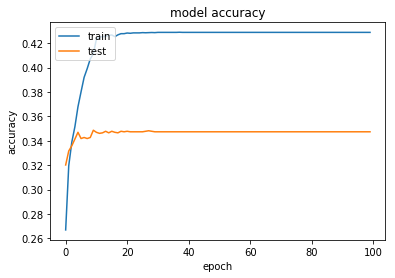

In [16]:
print(train_model.history.keys())
# summarize history for accuracy
plt.plot(train_model.history['acc'])
plt.plot(train_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


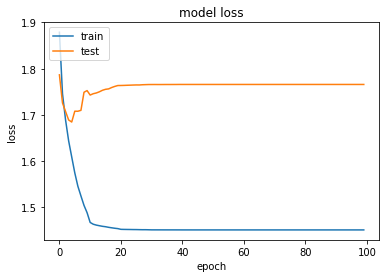

In [17]:
print(train_model.history.keys())
# summarize history for accuracy
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# testing image

In [20]:
from keras.models import load_model
model = load_model('/home/atif/training_by_several_learning_process/number_classify/rgb_2_gray/Image-classification/trained_model_text_file/image_size_8_data_type_float_trained_model/traffic_model_14_march_ep_100_int_val.h5')
#for gray scale
def preprocess_img(img):
#     Histogram normalization in y
#     hsv = color.rgb2hsv(img)
#     hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
#     img = color.hsv2rgb(hsv)

    # central scrop
    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]
    img = rgb2gray(img)

    # rescale to standard size
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    # roll color axis to axis 0
    img = np.rollaxis(img,-1)

    return img

import glob

path = r'/home/atif/training_by_several_learning_process/number_classify/rgb_2_gray/Image-classification/test_image/'

img_path = glob.glob(path+ '/*.ppm')
for image in img_path:
    X_test=[]
    X_test.append(preprocess_img(io.imread(image)))
    X_test = np.array(X_test)
#     plt.imshow(X_test)
    X_test = X_test.reshape(len(X_test),1,IMG_SIZE,IMG_SIZE)
    
    print("\n",image)
    predicted_class = model.predict_classes(X_test)
    print("predicted class: ",predicted_class)
    
    probability = model.predict_proba(X_test)
    print("probability: ",probability)


 /home/atif/training_by_several_learning_process/number_classify/rgb_2_gray/Image-classification/test_image/60_speed.ppm
predicted class:  [3]
probability:  [[2.7750938e-03 2.3004103e-02 8.1319185e-03 8.5185784e-01 3.2421786e-03
  1.0981418e-01 6.7189999e-06 8.1104453e-04 3.5697652e-04]]

 /home/atif/training_by_several_learning_process/number_classify/rgb_2_gray/Image-classification/test_image/50_speed.ppm
predicted class:  [2]
probability:  [[3.4383957e-05 2.1176649e-02 9.5949316e-01 6.4158160e-04 1.6614221e-02
  1.3603452e-03 7.3723786e-05 6.0574804e-04 7.3087470e-08]]

 /home/atif/training_by_several_learning_process/number_classify/rgb_2_gray/Image-classification/test_image/lorry.ppm
predicted class:  [8]
probability:  [[9.0368754e-05 6.3120089e-03 2.2581484e-05 1.5242946e-03 1.5791066e-02
  5.1691554e-02 1.0570022e-14 4.3715937e-07 9.2456764e-01]]

 /home/atif/training_by_several_learning_process/number_classify/rgb_2_gray/Image-classification/test_image/80_speed.ppm
predicted c

/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/atif/anaconda3/envs/venv/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [ ]:
print(X_test.shape)
print(X_test.ndim)
# plt.imshow(X_test[0])
X_test_show = X_test.reshape(IMG_SIZE,IMG_SIZE) # Need if you want to see the image\n",
print(X_test_show.shape)
plt.imshow(X_test_show)  # Displaying the image"